In [1]:
from pathlib import Path
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(Path().resolve(), '../..')))
from ImportHelper import ImportHelper
ImportHelper()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
#from tensorflow import keras
from sklearn import preprocessing
from AlphaVantageCommodities import AlphaVantageCommodities
from PandasDataFrameNormalizer import PandasDataFrameNormalizer
from dotenv import load_dotenv
import seaborn as sns
import datetime

load_dotenv()

2023-12-15 11:18:05.369198: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 11:18:05.369267: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 11:18:05.369286: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 11:18:05.375826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


True

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


2023-12-15 11:18:08.775300: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 11:18:08.779992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 11:18:08.780345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


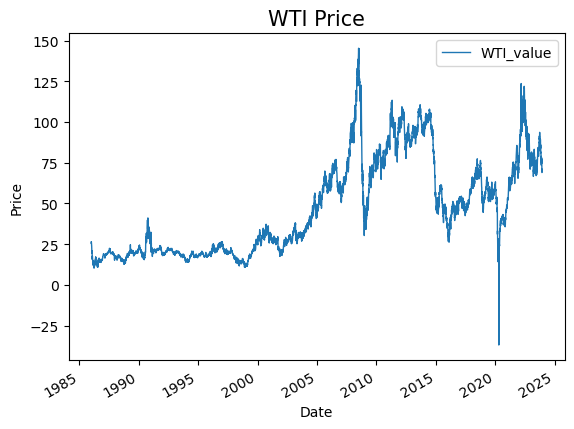

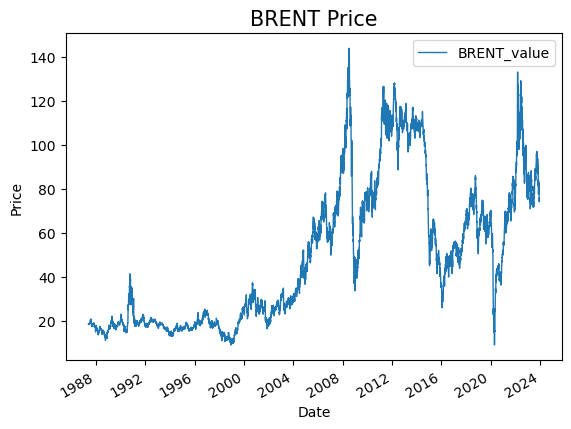

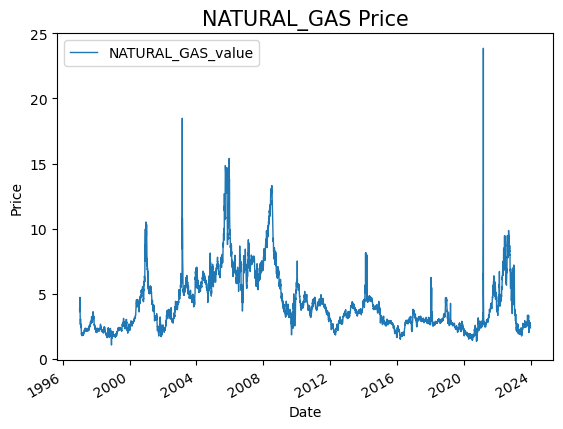

In [4]:
avc = AlphaVantageCommodities()
for symbol in avc.get_all_curated_series_ids():
    avc.plot_series_id(symbol)

In [56]:
df_merged = avc.get_data_as_pandas_df_multiple_series_ids(['WTI','BRENT','NATURAL_GAS'])

In [6]:
# keep nas for masking layer test
#df_merged = df_merged.dropna()

In [7]:
#df_merged = df_merged.dropna(subset=['WTI_value']).fillna(0)

In [57]:
df_merged = df_merged[df_merged['date'].ge('2018-01-01')]

In [58]:
df_merged.head()

,date,WTI_value,BRENT_value,NATURAL_GAS_value
8070,2018-01-02,60.369999,66.650002,6.24
8071,2018-01-03,61.610001,67.849998,6.24
8072,2018-01-04,61.980000,68.730003,4.65
8073,2018-01-05,61.490002,68.010002,NaN
8074,2018-01-08,61.730000,68.480003,2.89


<Axes: xlabel='date'>

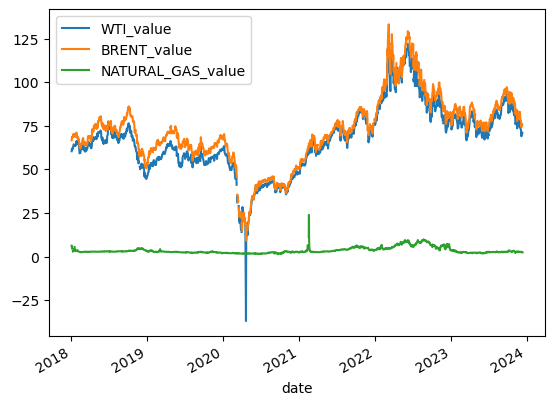

In [59]:
df_merged.plot(x="date")

<Axes: >

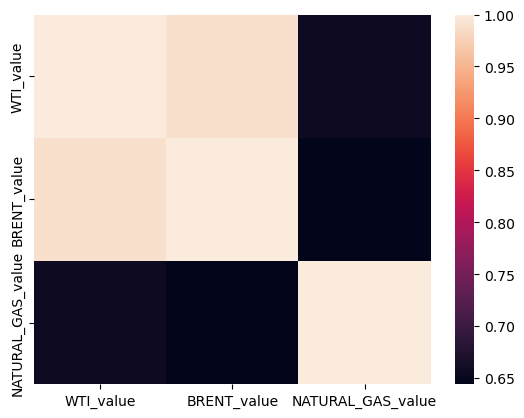

In [11]:
df_corr = df_merged.corr(numeric_only=True)
sns.heatmap(df_corr)

In [60]:
# Normalize data
normalizer_wti = PandasDataFrameNormalizer()
df_normalized = normalizer_wti.normalize_pandas_data_frame_column(df_merged,'WTI_value')

normalizer_brent = PandasDataFrameNormalizer()
df_normalized = normalizer_brent.normalize_pandas_data_frame_column(df_merged,'BRENT_value')

normalizer_natural_gas = PandasDataFrameNormalizer()
df_normalized = normalizer_natural_gas.normalize_pandas_data_frame_column(df_merged,'NATURAL_GAS_value')

In [61]:
df_normalized.tail()

,date,WTI_value,BRENT_value,NATURAL_GAS_value
9554,2023-12-06,0.659694,0.525633,0.063471
9555,2023-12-07,0.659818,0.524665,0.052818
9556,2023-12-08,0.671461,0.538610,0.055038
9557,2023-12-11,0.671959,0.537079,0.047048
9727,2023-12-12,NaN,NaN,0.046161


In [64]:
df_normalized = df_normalized.dropna(subset=['WTI_value']).fillna(-1)

In [65]:
df_normalized.head()

,date,WTI_value,BRENT_value,NATURAL_GAS_value
8070,2018-01-02,0.606089,0.463727,0.217932
8071,2018-01-03,0.613809,0.473400,0.217932
8072,2018-01-04,0.616113,0.480493,0.147359
8073,2018-01-05,0.613062,0.474690,-1.000000
8074,2018-01-08,0.614556,0.478478,0.069241


<Axes: xlabel='date'>

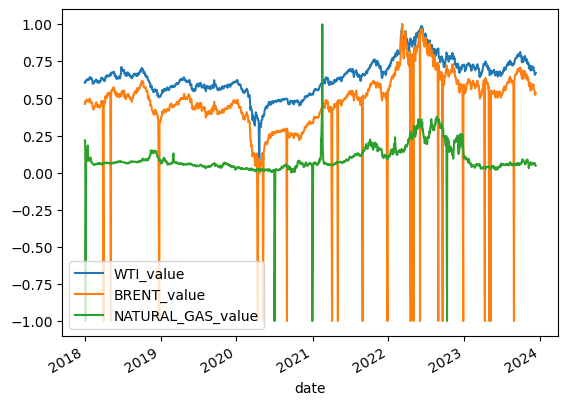

In [16]:
df_normalized.plot(x="date")

In [17]:
data = df_normalized[['WTI_value','BRENT_value','NATURAL_GAS_value']].to_numpy()
data

array([[0.60608894, 0.4637273 , 0.21793163],
       [0.613809  , 0.4734    , 0.21793163],
       [0.6161126 , 0.4804934 , 0.14735907],
       ...,
       [0.6598182 , 0.5246655 , 0.05281846],
       [0.6714606 , 0.5386104 , 0.05503772],
       [0.6719586 , 0.53707886, 0.04704838]], dtype=float32)

In [18]:
data.size

4464

In [19]:
np.shape(data)

(1488, 3)

In [20]:
print('Data lenght: ' + str(len(data)))

Data lenght: 1488


In [21]:
left_size = 0.8
split_at = int(left_size * len(data))
print('Split at: ' + str(split_at))

Split at: 1190


In [22]:
forecasting_label_steps = 1
feature_sequence_length = 100

x_train = data[0:split_at]
x_train_data = x_train[:-(feature_sequence_length+forecasting_label_steps)]
x_train_targets = x_train[feature_sequence_length+forecasting_label_steps:, 0]

x_test = data[split_at+1:]
x_test_data = x_test[:-(feature_sequence_length+forecasting_label_steps)]
x_test_targets = x_test[feature_sequence_length+forecasting_label_steps:, 0]

In [23]:
len(x_train_data)

1089

In [24]:
len(x_train_targets)

1089

In [25]:
len(x_test_data)

196

In [26]:
x_train_data[100:,0]

array([0.65309423, 0.64612126, 0.6550866 , 0.647242  , 0.63995767,
       0.6334205 , 0.63808995, 0.63335824, 0.64089155, 0.63970864,
       0.6417632 , 0.6435064 , 0.6450629 , 0.6468061 , 0.63497704,
       0.6405803 , 0.635475  , 0.64064246, 0.63914835, 0.65994275,
       0.6654838 , 0.6986055 , 0.7121778 , 0.6875233 , 0.69175696,
       0.69026273, 0.6921305 , 0.685033  , 0.6895779 , 0.6905118 ,
       0.69163245, 0.6689702 , 0.6677873 , 0.67245674, 0.654962  ,
       0.6537791 , 0.6584485 , 0.662433  , 0.66797405, 0.6529698 ,
       0.670838  , 0.6730794 , 0.6759432 , 0.65770143, 0.67345285,
       0.665297  , 0.65857303, 0.65950686, 0.65664303, 0.6598805 ,
       0.6608766 , 0.64686835, 0.6461835 , 0.65116423, 0.6489229 ,
       0.64761555, 0.6353505 , 0.6376541 , 0.6407048 , 0.6442535 ,
       0.64935875, 0.65265846, 0.6606276 , 0.66423863, 0.6658573 ,
       0.65695435, 0.66405183, 0.6676005 , 0.6650479 , 0.6649235 ,
       0.6578882 , 0.6524094 , 0.6519114 , 0.6507907 , 0.66162

In [27]:
x_train_data

array([[0.60608894, 0.4637273 , 0.21793163],
       [0.613809  , 0.4734    , 0.21793163],
       [0.6161126 , 0.4804934 , 0.14735907],
       ...,
       [0.9016312 , 0.8174271 , 0.3093653 ],
       [0.9036857 , 0.8301629 , 0.3146915 ],
       [0.91333586, 0.844269  , 0.31158456]], dtype=float32)

In [28]:
x_train_targets

array([0.64612126, 0.6550866 , 0.647242  , ..., 0.7445524 , 0.7393849 ,
       0.7277425 ], dtype=float32)

In [29]:
dataset_train = tf.keras.utils.timeseries_dataset_from_array(x_train_data, x_train_targets, sequence_length=feature_sequence_length, sampling_rate=1, batch_size=30)

2023-12-15 11:18:10.502815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 11:18:10.503390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 11:18:10.504133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 11:18:10.822155: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 11:18:10.822597: I tensorflow/compile

In [30]:
dataset_test = tf.keras.utils.timeseries_dataset_from_array(x_test_data, x_test_targets, sequence_length=feature_sequence_length, sampling_rate=1, batch_size=30)

In [31]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (30, 100, 3)
Target shape: (30,)


In [32]:
model = Sequential()

model.add(InputLayer(input_shape = (inputs.shape[1], inputs.shape[2])))

model.add(Masking(mask_value=-1))
#model.add(Dropout(0.2))

model.add(Dense(inputs.shape[2], kernel_initializer='he_uniform'))

#model.add(BatchNormalization())

model.add(LSTM(units = 100, return_sequences= True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences= True))
model.add(Dropout(0.2))

#model.add(LSTM(units = 200, return_sequences= True))
#model.add(Dropout(0.2))

#model.add(LSTM(units = 200, return_sequences= True))
#model.add(Dropout(0.2))

#model.add(LSTM(units = 50))
#model.add(Dropout(0.2))

model.add(Dense(units = 1, activation='linear'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mean_squared_logarithmic_error", metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 100, 3)            0         
                                                                 
 dense (Dense)               (None, 100, 3)            12        
                                                                 
 lstm (LSTM)                 (None, 100, 100)          41600     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 100)          80400     
                                                                 
 dropout_1 (Dropout)         (None, 100, 100)          0         
                                                                 
 dense_1 (Dense)             (None, 100, 1)            1

In [33]:
dt = datetime.datetime.now()
path_checkpoint = str(dt) + "_model_multi_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

In [34]:
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [35]:
history = model.fit(
    dataset_train,
    epochs=100,
    validation_data=dataset_test,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/100


2023-12-15 11:18:18.799365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-15 11:18:19.946421: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb56dd5b160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-15 11:18:19.946489: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-12-15 11:18:19.951483: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-15 11:18:20.032833: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 [==============================] - ETA: 0s - loss: 0.0210 - root_mean_squared_error: 0.2135 - mean_absolute_error: 0.1475 - mean_squared_error: 0.0456
Epoch 1: val_loss improved from inf to 0.01011, saving model to 2023-12-15 11:18:12.785708_model_multi_checkpoint.h5
33/33 [==============================] - 11s 109ms/step - loss: 0.0210 - root_mean_squared_error: 0.2135 - mean_absolute_error: 0.1475 - mean_squared_error: 0.0456 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1650 - val_mean_absolute_error: 0.1463 - val_mean_squared_error: 0.0270
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.0070 - root_mean_squared_error: 0.1257 - mean_absolute_error: 0.0909 - mean_squared_error: 0.0158
Epoch 2: val_loss did not improve from 0.01011
33/33 [==============================] - 1s 43ms/step - loss: 0.0070 - root_mean_squared_error: 0.1257 - mean_absolute_error: 0.0909 - mean_squared_error: 0.0158 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1966 - v

In [36]:
#history.history

<Axes: >

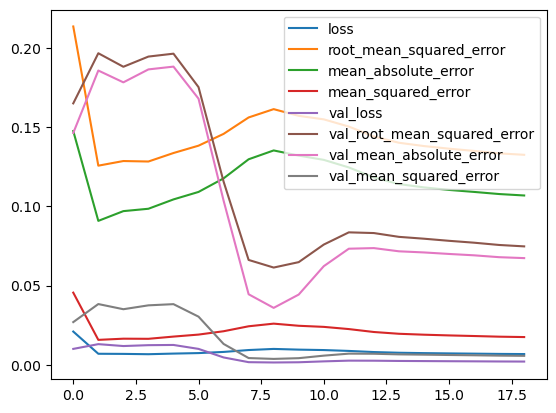

In [37]:
pd.DataFrame(history.history).plot()

In [39]:
model.load_weights(path_checkpoint)
# Re-evaluate the model
loss, rmse, mae, mse = model.evaluate(dataset_test, verbose=2)

4/4 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0614 - mean_absolute_error: 0.0360 - mean_squared_error: 0.0038 - 191ms/epoch - 48ms/step


In [40]:
def plot(input_data, predicted_data, output_compare, limit_right=None):
    if limit_right is not None:
        input_data = input_data[:limit_right]
        predicted_data = predicted_data[:limit_right]
        output_compare = output_compare[:limit_right]
        
    compare_y_shift = feature_sequence_length + forecasting_label_steps
    compare_y = list(range(compare_y_shift, compare_y_shift+ len(output_compare)))
    
    predicted_y_shift = feature_sequence_length + forecasting_label_steps
    predicted_y = list(range(predicted_y_shift, predicted_y_shift + len(predicted_data)))
    
    #input_data_limit = feature_sequence_length

    plt.figure(figsize=(20,6))
    plt.plot(input_data, label = "past", linestyle = 'dashed')
    plt.plot(predicted_y, predicted_data, label = "predicted")
    plt.plot(compare_y, output_compare, label = "real data", linestyle = 'dotted')
    plt.plot(feature_sequence_length, input_data[feature_sequence_length-1], "rx", label = "start prediction")
    plt.legend()
    plt.show()

In [41]:
for x, y in dataset_test.take(0):
    #print(x)
    #print(y)
    predicted_data = normalizer_wti.inverse_transform_numpy_array(model.predict(x.numpy()))
    #input_data = list(x.as_numpy_iterator())[0][0][:, 1]
    #print(x[:,0,0])
    input_data = normalizer_wti.inverse_transform_numpy_array(x[:, 0, 0].numpy())
    #print("input")
    #print(input_data)
    #output_compare = list(x.as_numpy_iterator())[0][1]
    output_compare = normalizer_wti.inverse_transform_numpy_array(y.numpy())
    #print("output")
    #print(output_compare)
    plot(input_data, predicted_data, output_compare)

In [42]:
for x, y in dataset_train.take(0):
    #print(x)
    #print(y)
    predicted_data = normalizer_wti.inverse_transform_numpy_array(model.predict(x.numpy()))
    #input_data = list(x.as_numpy_iterator())[0][0][:, 1]
    #print(x[:,0,0])
    input_data = normalizer_wti.inverse_transform_numpy_array(x[:, 0, 0].numpy())
    #print("input")
    #print(input_data)
    #output_compare = list(x.as_numpy_iterator())[0][1]
    output_compare = normalizer_wti.inverse_transform_numpy_array(y.numpy())
    #print("output")
    #print(output_compare)
    plot(input_data, predicted_data, output_compare)

In [43]:
predicted_dataset_train = model.predict(dataset_train)

33/33 [==============================] - 2s 22ms/step


In [44]:
len(predicted_dataset_train)

990

In [45]:
len(predicted_dataset_train[:,0])

990

In [46]:
x_train_data[:,0]

array([0.60608894, 0.613809  , 0.6161126 , ..., 0.9016312 , 0.9036857 ,
       0.91333586], dtype=float32)

In [47]:
# inverse transforms
normalizer_wti.inverse_transform_numpy_array(x_train_data[:,0])
normalizer_wti.inverse_transform_numpy_array(predicted_dataset_train[:,0])
normalizer_wti.inverse_transform_numpy_array(x_train_targets)

array([66.79999 , 68.240005, 66.98001 , ..., 82.61    , 81.78    ,
       79.91    ], dtype=float32)

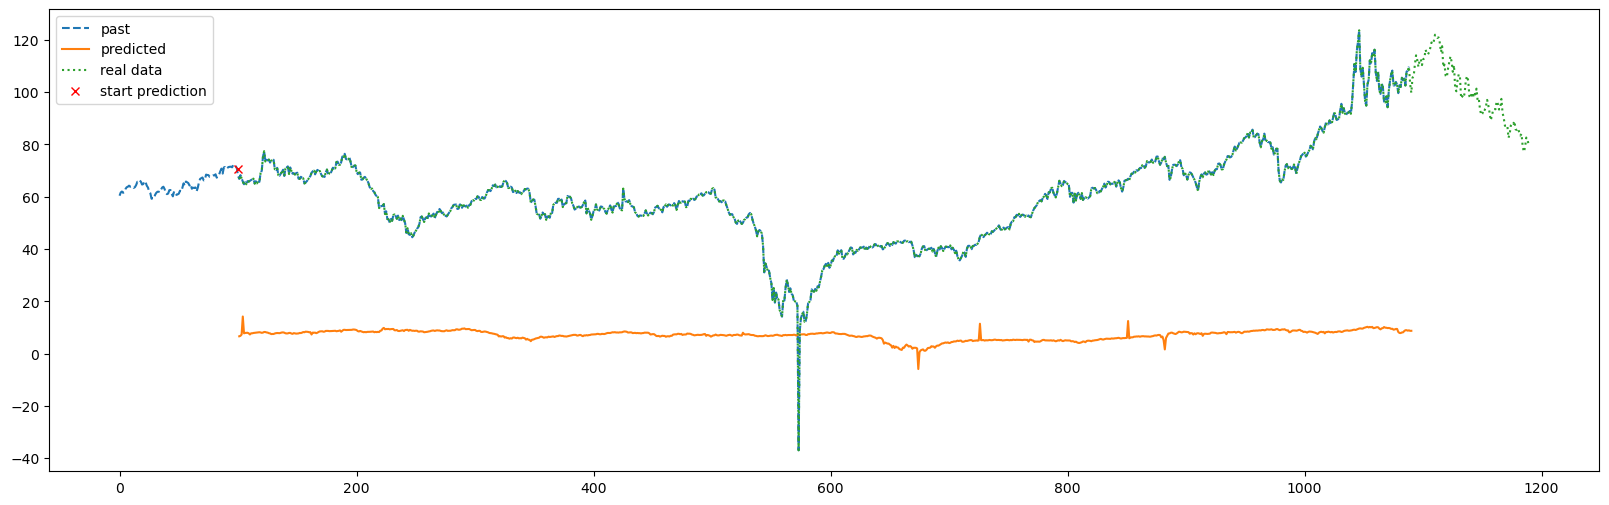

In [48]:
plot(
    normalizer_wti.inverse_transform_numpy_array(x_train_data[:,0]),
    normalizer_wti.inverse_transform_numpy_array(predicted_dataset_train[:,0]),
    normalizer_wti.inverse_transform_numpy_array(x_train_targets)
    #limit_right=400
)

In [49]:
predicted_dataset_test = model.predict(dataset_test)

4/4 [==============================] - 0s 34ms/step


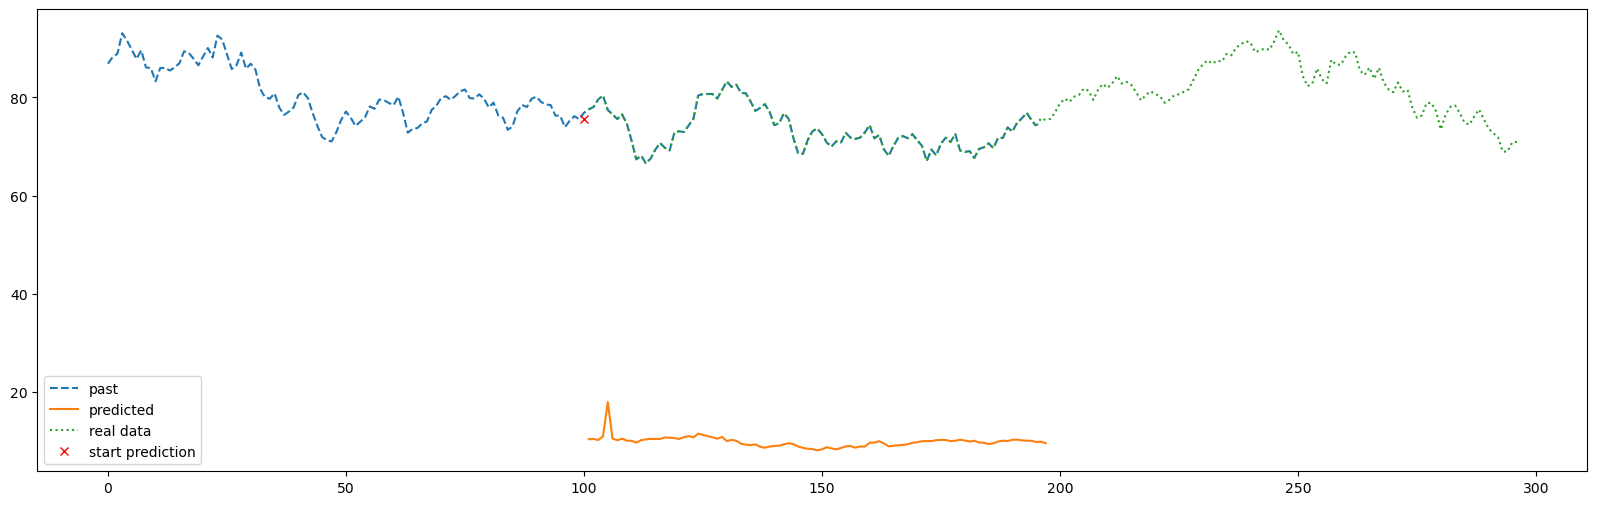

In [50]:
plot(
    normalizer_wti.inverse_transform_numpy_array(x_test_data[:,0]),
    normalizer_wti.inverse_transform_numpy_array(predicted_dataset_test[:,0]), 
    normalizer_wti.inverse_transform_numpy_array(x_test_targets), 
    #limit_right=400
)